In [2]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

In [3]:
RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

Normalized Predictions: [5. 2. 5. ... 3. 3. 4.]
train: 0       3
1       1
2       3
3       1
4       6
       ..
5766    5
5767    1
5768    1
5769    2
5770    9
Name: decile_score, Length: 5771, dtype: int64
Mean Squared Error: 5.044879570265119
R-squared Score: 0.37350941834997764
Intercept (w_0): 4.498353838156299
Coefficients (w_1, w_2, ...): [-1.0988714   0.21162846  0.80234679  0.02079777 -0.75142655  0.09758879
 -0.09758879]
                   Feature  Coefficient
0                      age    -1.098871
1             priors_count     0.211628
2      history_of_violence     0.802347
3  days_b_screening_arrest     0.020798
4  socioeconomic_stability    -0.751427
5        c_charge_degree_F     0.097589
6        c_charge_degree_M    -0.097589


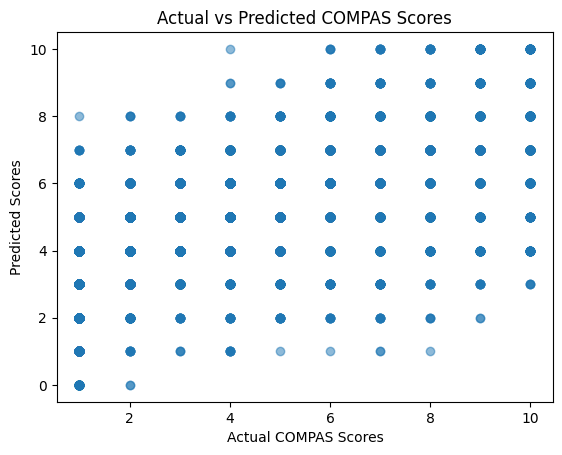

In [7]:

# Load the dataset (replace 'train_dataset.csv' with your dataset path)
df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_train = pd.read_csv(df_train_path)

# Feature Engineering

# Composite feature for history_of_violence
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)

# Socioeconomic stability proxy
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"])) 

# Select relevant features for the COMPAS equation
X_train = df_train[[ 
    "age", "priors_count", "history_of_violence", "days_b_screening_arrest", 
    "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"
]]

y_train_compas = df_train["decile_score"]
y_train = df_train["two_year_recid"] * 10

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_train_scaled)
# Normalize the predicted values to the range [0, 10]
#y_pred_normalized =  10 * (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
#y_pred_normalized = 10 / (1 + np.exp(-y_pred))
y_pred_normalized =  np.clip( np.ceil(y_pred), 0, 10)



print("Normalized Predictions:", y_pred_normalized)
print("train:", y_train_compas) 


# Evaluate the model
mse = mean_squared_error(y_train_compas, y_pred_normalized)
r2 = r2_score(y_train_compas, y_pred_normalized)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Coefficients (interpretable weights)
print("Intercept (w_0):", model.intercept_)
print("Coefficients (w_1, w_2, ...):", model.coef_)

# Feature importance
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})
print(coefficients)

# Visualization: Actual vs Predicted
import matplotlib.pyplot as plt
plt.scatter(y_train_compas, y_pred_normalized, alpha=0.5)
plt.xlabel("Actual COMPAS Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted COMPAS Scores")
plt.show()







Predicted Risk Group vs Two-Year Recidivism Summary:
two_year_recid           0     1
Predicted_Risk_Group            
Low                   1712   594
Medium                1364  1614
High                    99   388


/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df_train.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)


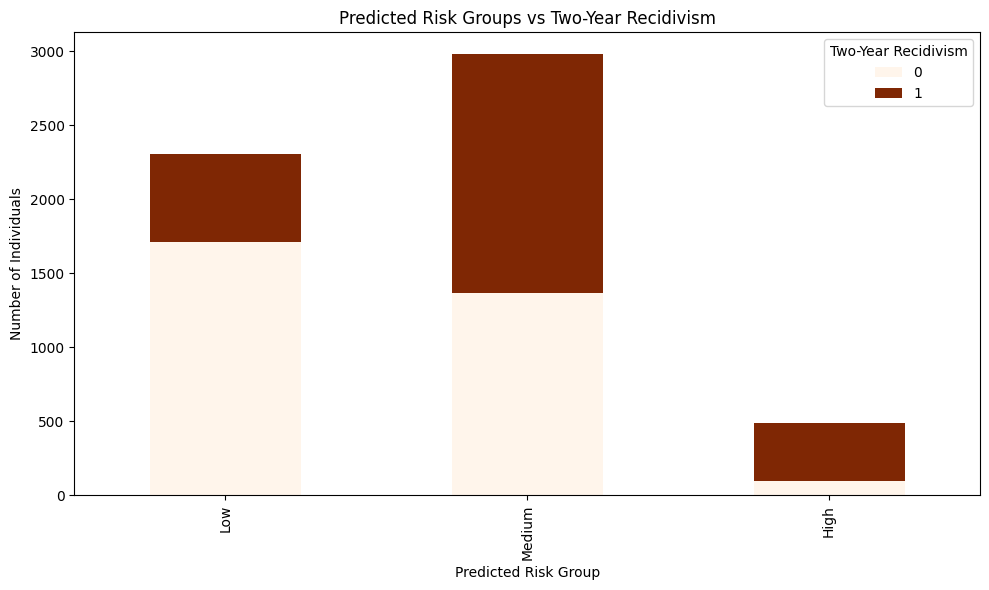

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_comparison = df_train.groupby(["race", "Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_race = race_data.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_32953/4164303440.py:54: FutureWarning: The default of observed=False is depre


Race-Based Comparison of Predicted Risk Groups vs Two-Year Recidivism:
two_year_recid                           0    1
race             Predicted_Risk_Group          
African-American Low                   607  247
                 Medium                761  970
                 High                   72  300
Asian            Low                    15    2
                 Medium                  2    6
                 High                    1    0
Caucasian        Low                   756  249
                 Medium                426  449
                 High                   18   65
Hispanic         Low                   198   60
                 Medium                113  117
                 High                    7   14
Native American  Low                     4    2
                 Medium                  4    2
                 High                    0    2
Other            Low                   132   34
                 Medium                 58   70
                

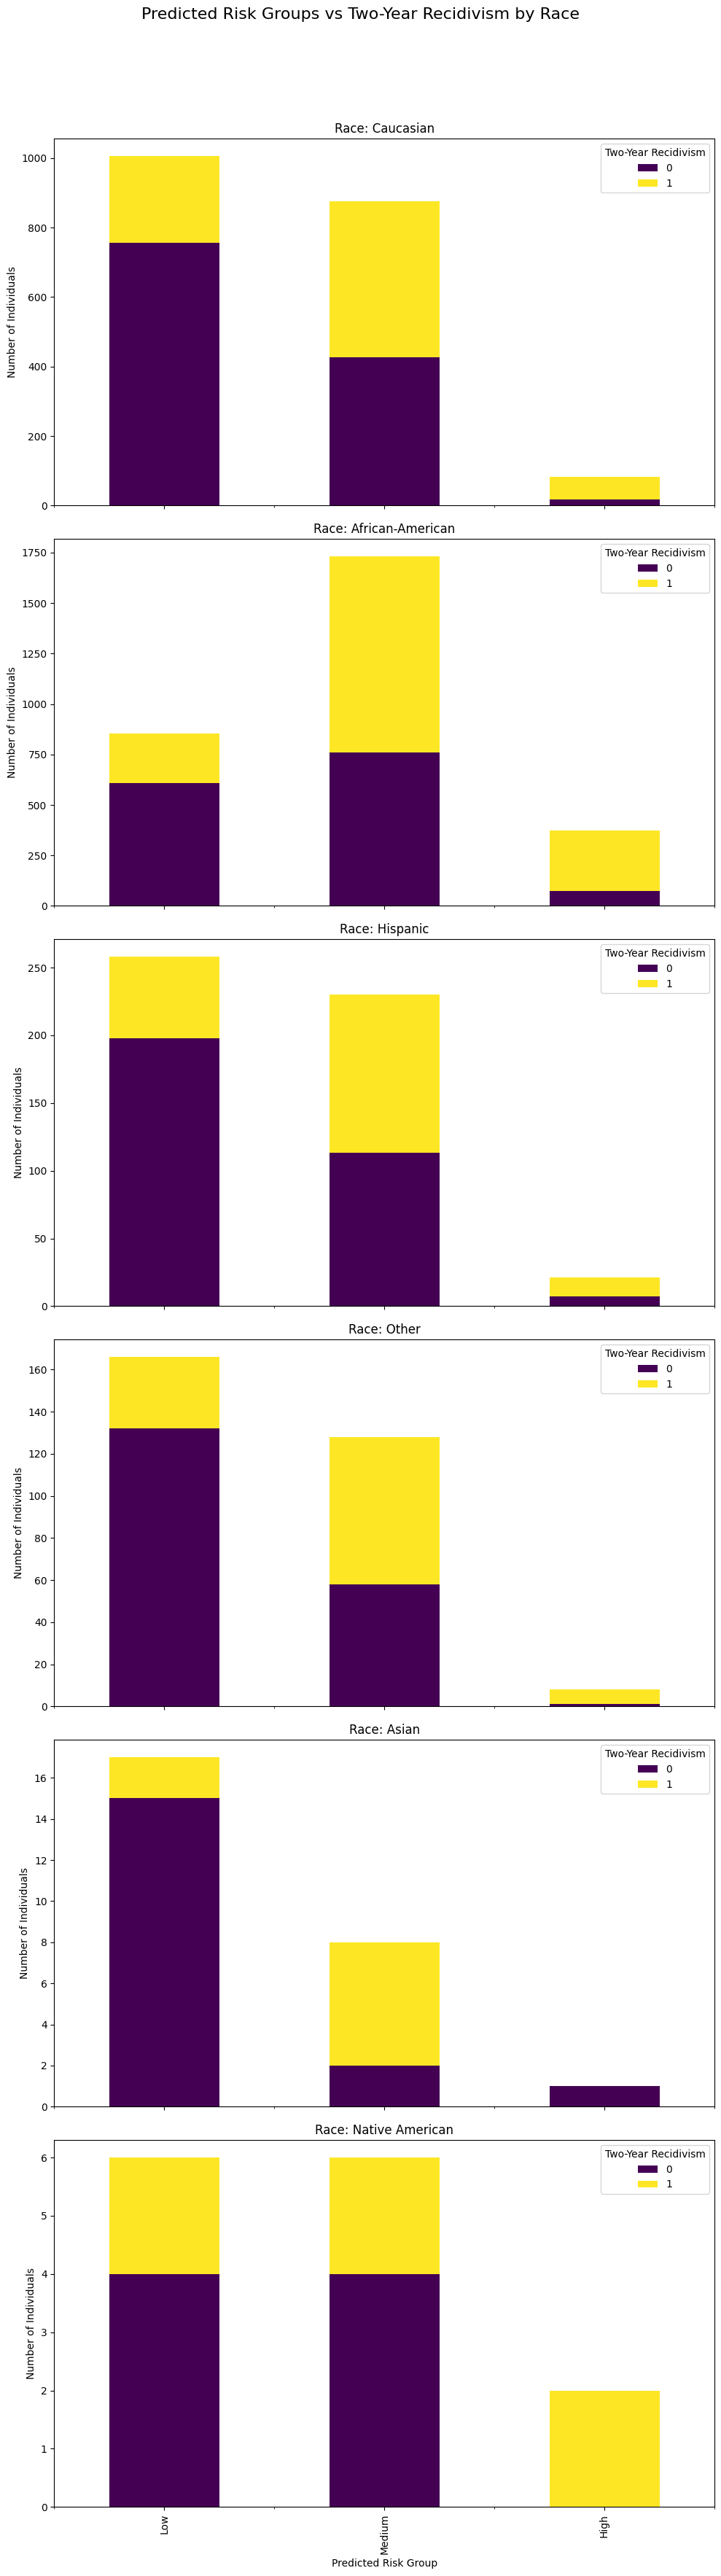

In [12]:


# Categorize predictions into risk groups
def categorize_score(score):
    if score <= 4:
        return "Low"
    elif 5 <= score <= 7:
        return "Medium"
    else:
        return "High"

# Add predicted risk group to DataFrame
df_train["Predicted_Risk_Group"] = pd.Categorical(
    pd.Series(y_pred_normalized).map(categorize_score), categories=["Low", "Medium", "High"], ordered=True
)

# Group by Predicted Risk Group and Two-Year Recidivism
predicted_grouped = df_train.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

# Save results to CSV
predicted_grouped.to_csv("predicted_vs_recid_summary.csv")

# Print summary table
print("Predicted Risk Group vs Two-Year Recidivism Summary:")
print(predicted_grouped)

# Visualization: Predicted Risk Groups vs Two-Year Recidivism
predicted_grouped.plot(
    kind="bar",
    stacked=True,
    colormap="Oranges",
    figsize=(10, 6),
    title="Predicted Risk Groups vs Two-Year Recidivism"
)
plt.xlabel("Predicted Risk Group")
plt.ylabel("Number of Individuals")
plt.legend(title="Two-Year Recidivism", loc="upper right")
plt.tight_layout()
plt.show()

# Combine Predictions with Race for Analysis
race_comparison = df_train.groupby(["race", "Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

# Save race-based analysis to CSV
race_comparison.to_csv("predicted_risk_by_race_summary.csv")
print("\nRace-Based Comparison of Predicted Risk Groups vs Two-Year Recidivism:")
print(race_comparison)

# Visualization: Race-Based Comparison
races = df_train["race"].unique()
fig, axes = plt.subplots(len(races), 1, figsize=(10, 6 * len(races)), sharex=True)
plt.suptitle("Predicted Risk Groups vs Two-Year Recidivism by Race", fontsize=16)

for i, race in enumerate(races):
    race_data = df_train[df_train["race"] == race]
    grouped_race = race_data.groupby(["Predicted_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
    
    grouped_race.plot(
        kind="bar",
        stacked=True,
        ax=axes[i],
        colormap="viridis",
        title=f"Race: {race}",
    )
    axes[i].set_ylabel("Number of Individuals")
    axes[i].legend(title="Two-Year Recidivism", loc="upper right")

plt.xlabel("Predicted Risk Group")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
